# <center>Estimating Risk and Uncertainty in Deep Reinforcement Learning</center>
## <center> CartPole Generalization experiment</center>

### Essential libraries

In [1]:
import pickle

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.interpolate import interp1d

from qrdqn import QRDQN # QRDQN with epsilon-greedy exploration strategy
from eqrdqn import EQRDQN #EQRDQN corresponds to QRDQN with a Thompson sampling exploration strategy
from mlp import MLP, MLP_Multihead

### Hyperparameters

In [2]:
# Number of seeds. N_SEEDS = 100 is used in the article
N_SEEDS = 100

# Bounds of the interval of starting positions
BOUND_LEFT = -2.
BOUND_RIGHT = 2.

#In Cartpole, an episode consists of at most 200 steps  
MAX_EPISODE_LENGTH = 200

# Training steps
nb_steps = 25000

# x-axis linspaces for the generalization scores and training curves 
NUM_DISCRETIZE = 200
x = np.linspace(BOUND_LEFT , BOUND_RIGHT, num=NUM_DISCRETIZE, endpoint=True) # generalization
xtrain = np.linspace(MAX_EPISODE_LENGTH + 50, nb_steps-MAX_EPISODE_LENGTH-50, num=NUM_DISCRETIZE*3, endpoint=True) # training

### Train two QRDQN agents in the CartPole environment, with different exploration strategies, and test on different starting positions

In [ ]:
final_res = np.zeros((2,N_SEEDS,NUM_DISCRETIZE)) # Scores for each agent (QRDQN and EQRDQN), seed and starting position 
training_curves = np.zeros((2,N_SEEDS,NUM_DISCRETIZE*3)) # Training curves for each agent (QRDQN and EQRDQN), seed and starting position 
for j in range(N_SEEDS):
    print('Seed : ' + str(j))
    env = gym.make("CartPole-v0")

    # Note that we use the same parameters for both for fair comparison
    agents = [EQRDQN(
        env = env,
        network=MLP_Multihead,
        n_quantiles = 20,
        kappa= 10,
        prior= 0.1,
        replay_start_size = 1000,
        replay_buffer_size = 50000,
        gamma = 0.99,
        update_target_frequency = 500,
        minibatch_size= 32,
        learning_rate = 1e-3,
        update_frequency = 4,
        adam_epsilon = 1e-8,
        logging = True,
    ),
    QRDQN(
        env = env,
        network=MLP,
        n_quantiles = 20,
        kappa = 10,
        replay_start_size = 1000,
        replay_buffer_size = 50000, 
        gamma = 0.99,
        update_target_frequency = 500,
        minibatch_size = 32,
        learning_rate = 1e-3,
        update_frequency = 4,
        initial_exploration_rate = 1,
        final_exploration_rate = 0.02,
        final_exploration_step = 5000,
        adam_epsilon = 1e-8,
        logging = True,
    )]
    names = ['QRDQN-Thompson sampling', 'QRDQN-epsilon greedy']

    for i in range(len(agents)):
        print('Agent : '+ names[i], ', Training ongoing...')
        #Training
        agents[i].learn(timesteps=nb_steps, verbose=False)
        agents[i].save()

        # Get the learning curves and interpolate
        logdata = pickle.load(open("log_data.pkl", 'rb'))
        scores = np.array(logdata['Episode_score'])
        ftrain = interp1d(scores[:, 1], scores[:, 0], kind='nearest')

        # Generate a random starting position between BOUND_LEFT and BOUND_RIGHT at each reset
        obs = env.reset()
        generated_pos = env.env.np_random.uniform(low=BOUND_LEFT, high=BOUND_RIGHT)
        obs[0] = generated_pos
        env.env.state[0] = generated_pos
        starting_positions = []
        starting_positions.append(generated_pos)
        
        returns_list = []
        returns = 0
        print('Training Done. Testing on different starting positions...')
        for _ in range(100000):
            
            action = agents[i].predict(torch.FloatTensor(obs))
            obs, rew, done, info = env.step(action)
            returns += rew

            if done:
                returns_list.append(returns)
                returns = 0
                # Generate a random starting position between BOUND_LEFT and BOUND_RIGHT at each reset
                obs = env.reset()
                generated_pos = env.env.np_random.uniform(low=BOUND_LEFT, high=BOUND_RIGHT)
                obs[0] = generated_pos
                env.env.state[0] = generated_pos
                starting_positions.append(generated_pos)
        print('Testing Done.')
        
        # Align the returns with increasing starting positions, and add bounds for easier interpolation 
        starting_positions = starting_positions[:len(returns_list)]
        returns_list = [returns_list[i] for i in sorted(range(len(starting_positions)), key=lambda k: starting_positions[k])]
        starting_positions = [BOUND_LEFT] + sorted(starting_positions)
        starting_positions.append(BOUND_RIGHT)
        returns_list = [returns_list[0]] + returns_list
        returns_list.append(returns_list[-1])
        
        # Get the interpolation function 
        fscores = interp1d(starting_positions, returns_list, kind='nearest')
        
        # Store the final results
        final_res[i,j] = fscores(x)
        training_curves[i,j] = ftrain(xtrain)

### Plot results

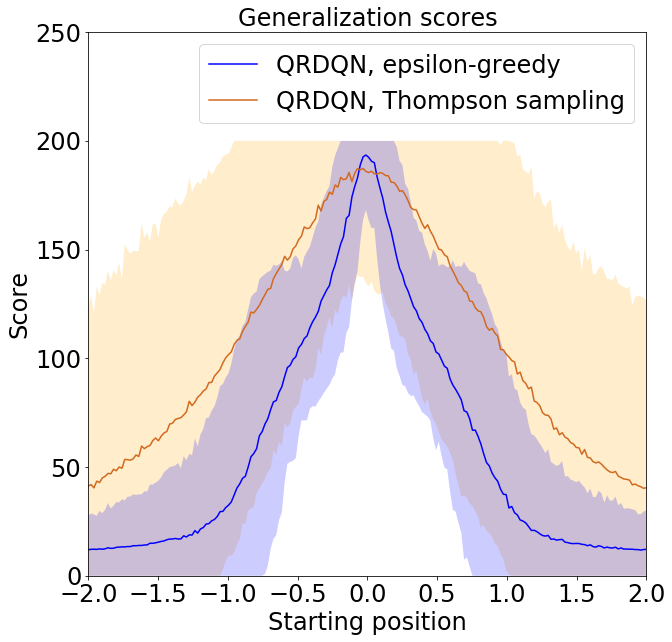

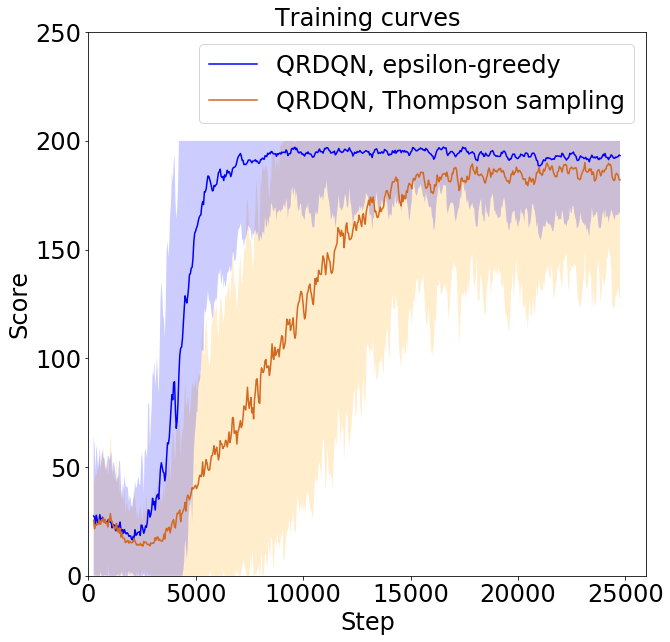

In [24]:
def plot_mean_and_confidence_intervals(x, results_array):
    plt.figure(figsize=(10,10))
    mean_TS = results_array[0].mean(axis=0)
    std_TS = results_array[0].std(axis=0)
    mean_epsilon = results_array[1].mean(axis=0)
    std_epsilon = results_array[1].std(axis=0)
    
    plt.plot(x, mean_epsilon, label = 'QRDQN, epsilon-greedy', color = 'blue')
    plt.plot(x, mean_TS, label = 'QRDQN, Thompson sampling', color = 'chocolate')
    plt.fill_between(x,
                np.maximum(mean_TS - 1.96* std_TS,0),
                np.minimum(mean_TS + 1.96* std_TS,200.),
                facecolor='orange',
                alpha=0.2)
    plt.fill_between(x,
                np.maximum(mean_epsilon - 1.96* std_epsilon,0),
                np.minimum(mean_epsilon + 1.96* std_epsilon,200.),
                facecolor='blue',
                alpha=0.2)

# Plot generalization scores
plot_mean_and_confidence_intervals(x, final_res)
plt.title('Generalization scores', fontsize=24)
plt.xlabel('Starting position', fontsize=24)
plt.ylabel('Score', fontsize=24)
plt.xlim(-2,2)
plt.ylim(0,250)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend( prop={'size': 24})
plt.show()

# Plot training curves
plot_mean_and_confidence_intervals(xtrain, training_curves)
plt.title('Training curves', fontsize=24)
plt.xlabel('Step', fontsize=24)
plt.ylabel('Score', fontsize=24)
plt.xlim(0)
plt.ylim(0,250)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend( prop={'size': 24})
plt.show()